In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from itertools import combinations
import hdbscan
from scipy.spatial import cKDTree

DATA_PATH = "/home/kartik/layout-analysis/stress-test-data"
SAMPLE_SIZE = 6  

In [ ]:
#HYPERPARAMETERS
NUM_NEIGHBOURS = 16


# for each point, get closest 16 neighbours as per the euclidian distance (including itself)
    # normalize such that the current point is (0,0) and the neighbours are atmost 1 distance away (while maintaining aspect ratio)
    # select pairs of neighbours, such that the current point is in the middle of the pair of two points


# filter top 8 neighbours
# filter only opposite 
# filter only 'horizontal' (AI)
# filter only the shortest 
# if one of the two connections is too long, cut it (AI)

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_2_points.txt


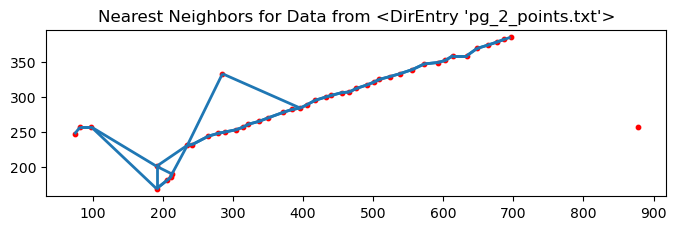

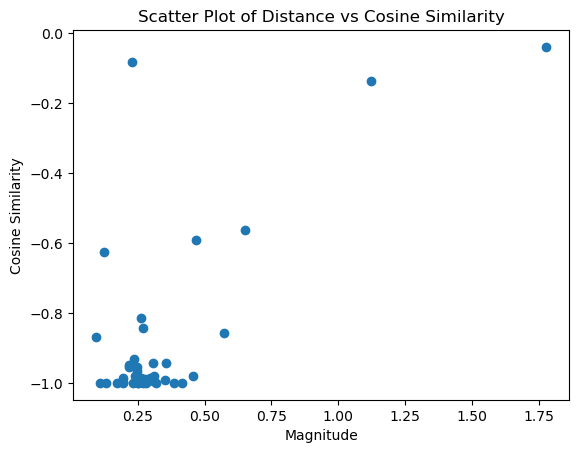

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_0_points.txt


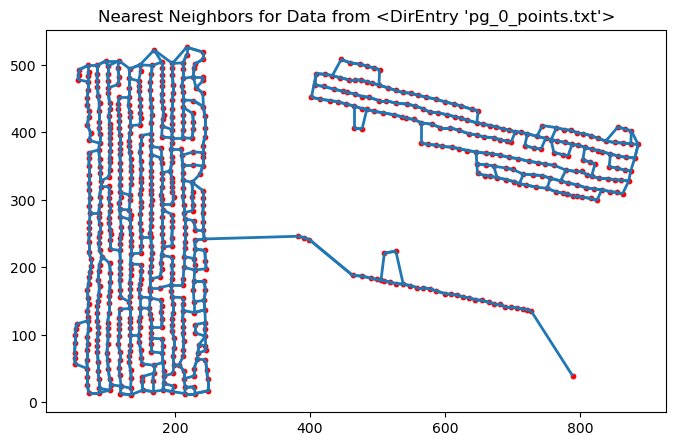

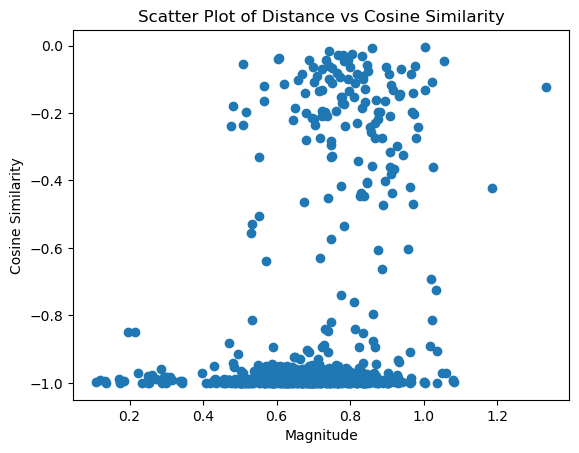

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_5_points.txt


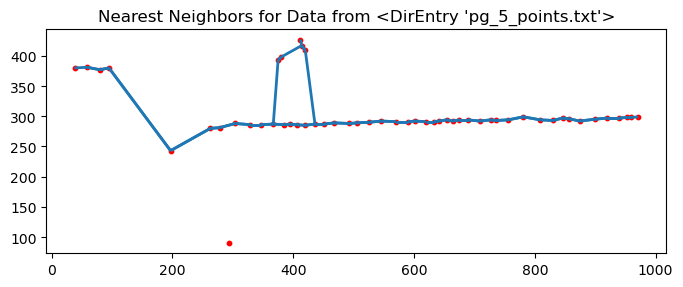

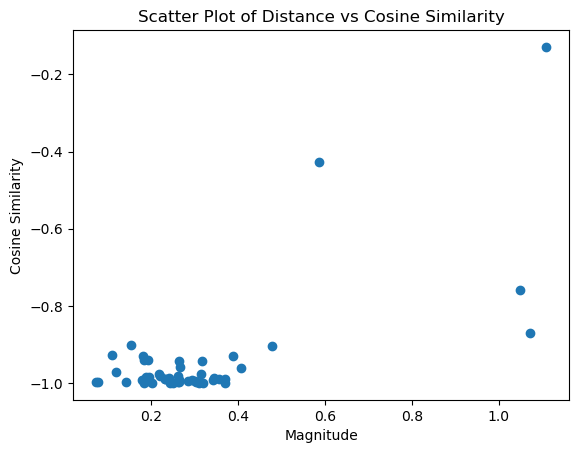

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_4_points.txt


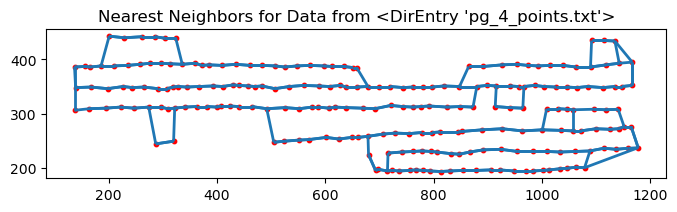

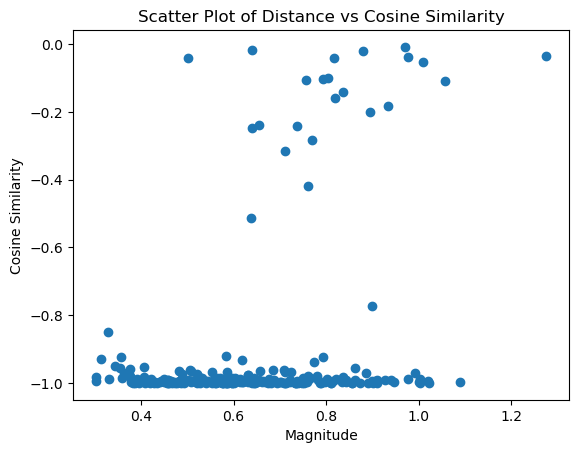

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_1_points.txt


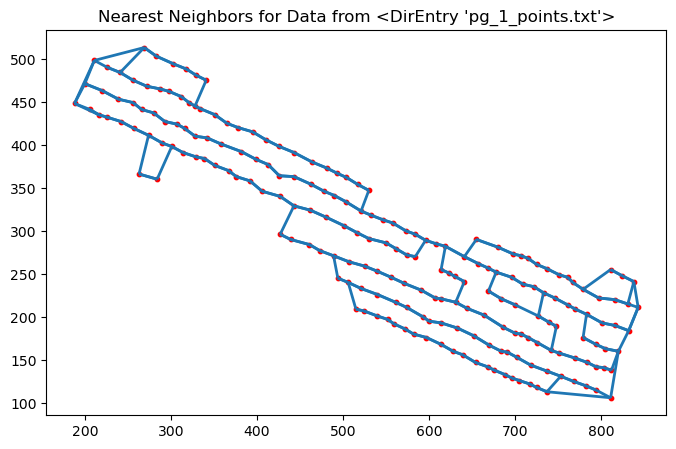

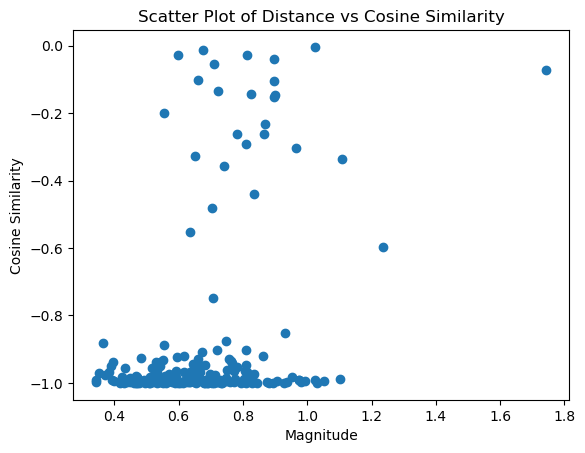

Processing file: /home/kartik/layout-analysis/stress-test-data/pg_3_points.txt


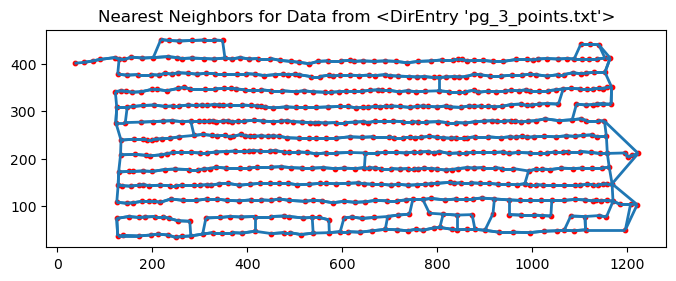

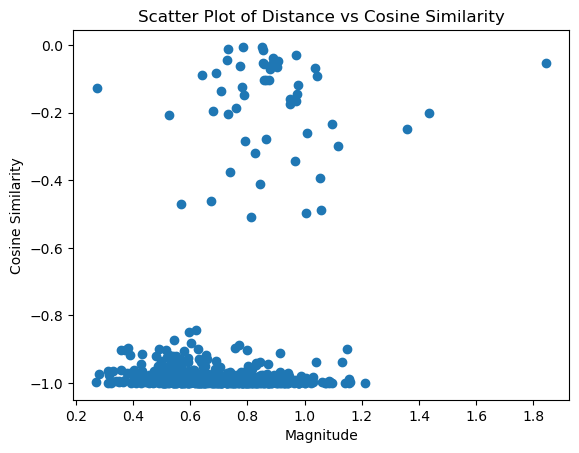

In [9]:
# Get unique prefixes efficiently without sorting everything
for entry in os.scandir(DATA_PATH):
    # Process only files that end with '.txt'
    if entry.is_file() and entry.name.endswith('.txt'):
        points_file = entry.path  # Full path to the current points file
        print(f"Processing file: {points_file}")
        points = np.loadtxt(points_file)
        
        # Build a KD-tree for fast nearest neighbor lookups based on the points
        tree = cKDTree(points)
        _, indices = tree.query(points, k=NUM_NEIGHBOURS)

        segments = [] 
        to_cluster = []
        to_plot = []


        # for each point, get closest 16 neighbours as per the euclidian distance (including itself)
        # shape of indices is [num of points on the page, nummber of neighbours]
        for current_point_index, nbr_indices in enumerate(indices):
            # normalize such that the current point is (0,0) and the neighbours are atmost 1 distance away (while maintaining aspect ratio)
            normalized_points = points[nbr_indices] - points[current_point_index]
            scaling_factor = np.max(np.abs(normalized_points))
            if scaling_factor == 0:
                scaling_factor = 1
            scaled_points = normalized_points / scaling_factor
            relative_neighbours = [(global_idx, sp)
                                for global_idx, sp in zip(nbr_indices, scaled_points)]


            # select pairs of neighbours whose angle is more than 90
            filtered_neighbours = []
            for _a, _b in combinations(relative_neighbours,2):
                relative_vector1 = _a[1]
                relative_vector2 = _b[1]
                norm1 = np.linalg.norm(relative_vector1)
                norm2 = np.linalg.norm(relative_vector2)
                if norm1 * norm2 == 0:
                    cos_similarity = 0.0
                else:
                    cos_similarity = np.dot(_a[1], _b[1]) / (norm1 * norm2)                
                if cos_similarity < 0.0: 
                    total_distance = norm1+norm2
                    filtered_neighbours.append((_a,_b,total_distance,cos_similarity))


            if len(filtered_neighbours)!=0:
                shortest_two_neighbours = min(filtered_neighbours, key=lambda x: x[2])
                _connection_1 = shortest_two_neighbours[0]
                _connection_2 = shortest_two_neighbours[1]
                distance = shortest_two_neighbours[2]
                cos_similarity = shortest_two_neighbours[3]

                idx_connection_1 = _connection_1[0]
                idx_connection_2 = _connection_2[0]
                to_plot.append((current_point_index,idx_connection_1,idx_connection_2))
                to_cluster.append((distance,cos_similarity))


        for s in to_plot:
            segments.append((points[s[0]],points[s[1]]))
            segments.append((points[s[0]],points[s[2]]))
        # Create the LineCollection with the list of colors
        lc = mc.LineCollection(segments,  linewidths=2, alpha=1)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c='red', s=10)
        ax.set_title(f"Nearest Neighbors for Data from {entry}")
        ax.set_aspect('equal')
        plt.show()

        # Unpack the tuples into separate lists for x and y values
        distances, cos_similarities = zip(*to_cluster)
        # Create the scatter plot
        plt.scatter(distances, cos_similarities)
        # Label the axes and add a title
        plt.xlabel('Magnitude')
        plt.ylabel('Cosine Similarity')
        plt.title('Scatter Plot of Distance vs Cosine Similarity')
        # Display the plot
        plt.show()

In [ ]:
#TODO
# image to heatmap to pointcloud -- has to be consistent
# ensure consistant connection (over scale and rotation)
# anomaly detection - remove
                                
